# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset criado a partir de um grafo causal implícito

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_num = pd.read_csv('data/shap_dataset_example_50k_samples.csv')

In [3]:
df_num = df_num.rename(columns={"Delivery_price_proportion":"Free_shipment"})

In [4]:
for i in range(df_num.shape[0]):
    if df_num['Free_shipment'].iloc[i] <0.3:
        df_num['Free_shipment'].iloc[i] = -1
    elif df_num['Free_shipment'].iloc[i] >=0.3:
        df_num['Free_shipment'].iloc[i] = 0

In [5]:
df_num['Free_shipment'] = df_num['Free_shipment'].replace(-1,1)
df_num['Click_probability'] = np.round(df_num['Click_probability'],2)
df_num['Image_quality'] = np.round(df_num['Image_quality'],0)
df_num['Product_price'] = np.round(df_num['Product_price'],2)

In [6]:
df_num.to_csv('data/shap_dataset_50k_modified.csv',index=False)

In [7]:
df_num[df_num["Free_shipment"]==1].shape[0]/df_num.shape[0]

0.26368

In [8]:
df_num.head()

,Image_quality,Number_of_images,Product_price,Seller_latitude,Seller_longitude,Free_shipment,Click_probability
0,4.0,6.0,21.41,0.2,-0.3,0.0,0.44
1,4.0,6.0,15.78,1.9,-0.5,0.0,0.40
2,6.0,4.0,16.11,2.2,2.6,1.0,0.47
3,6.0,5.0,18.84,1.3,5.2,1.0,0.60
4,5.0,5.0,24.17,-0.7,0.3,0.0,0.43


---
### Funções de auxílio

In [9]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D fake')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def gan_summary(df_num,rho):
    oh = np.eye(2)
    batch = X_tc.shape[0]
    l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
    l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
    l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch, W_dim).cuda()
    g = G(z,w,l_s_)
    g = torch.Tensor(scaler.inverse_transform(g.cpu().data.numpy())).type(torch.FloatTensor).cuda()
    x_gen = torch.cat((g[:,0:5],l_s,g[:,5:]),dim=1)

    df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

    df_g['Click_probability'] = np.round(df_g['Click_probability'].values,2)
    df_g['Image_quality'] = np.round(df_g['Image_quality'].values,0)
    df_g['Number_of_images'] = np.round(df_g['Number_of_images'].values,0)
    df_g['Product_price'] = np.round(df_g['Product_price'].values,2)
    
    df_g['Expected_income'] = df_g['Product_price'] * df_g['Click_probability']
    df_num['Expected_income'] = df_num['Product_price'] * df_num['Click_probability']

    #dataset fake
    print("Fake total expected income: {:.2f}\n".format(df_g['Expected_income'].sum()),df_g[['Product_price','Click_probability','Expected_income']].describe().loc[['mean','std','25%','50%','75%']])

    #dataset real
    print("Real total expected income: {:.2f}\n".format(df_num['Expected_income'].sum()),df_num.describe()[['Product_price','Click_probability','Expected_income']].loc[['mean','std','25%','50%','75%']])

    for col in ['Product_price','Click_probability','Expected_income']:
        plt.figure(figsize=(10,3))
        sns.distplot(df_num[col],label='Real')
        sns.distplot(df_g[col],label='Fake')
        plt.legend(loc=0)
        plt.grid(True)
        plt.show()
    
    df_g.drop('Expected_income',axis=1,inplace=True)
    df_num.drop('Expected_income',axis=1,inplace=True)

def noise(dim0,dim1):
    return Variable(Normal(loc=0, scale=5).sample(sample_shape=torch.Size([dim0,dim1])))

def noise_uniform(dim0,dim1):
    return Variable(Uniform(-5,5).sample(sample_shape=torch.Size([dim0,dim1])))

def torch_kurtosis(x):
    return Variable(torch.Tensor(kurtosis(x.cpu().data.numpy(),axis=0))).type(torch.FloatTensor)

def torch_skew(x):
    return Variable(torch.Tensor(skew(x.cpu().data.numpy(),axis=0))).type(torch.FloatTensor)

---

## ConditionalGAN

- Label: usaremos apenas um label, `bigode`.
- Gerador: receberá o ruído `z` e a label `y` e retornará o dado `G(z,y)`.
- Discriminador: receberá `G(z,y)` e `z` e retornará a probabilidade do dado ser real.

In [10]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.distributions import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
# probabilidade de ocorre bigode=1 no dataset
rho = df_num[df_num["Free_shipment"]==1].shape[0]/df_num.shape[0]
rho

0.26368

In [12]:
X_data = df_num.drop("Free_shipment",axis=1).copy().values
scaler.fit(X_data)
X_data = scaler.transform(X_data)
y_data = pd.get_dummies(df_num["Free_shipment"]).values.reshape(X_data.shape[0],2)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([50000, 6]) torch.FloatTensor torch.Size([50000, 2]) torch.FloatTensor


In [13]:
Z_dim,W_dim,h_dim,X_dim,y_dim = [50,10,60,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+W_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,w,l):
        h = F.relu(self.hidden(torch.cat((z,w,l),dim=1)))
        h = nn.Dropout(p=0.25)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        y = torch.sigmoid(self.out(h))
        return y

In [14]:
# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
lrg,lrd = [1e-4,1e-4]
G_optim = optim.Adam(G.parameters(),lr=lrg,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrg*0.,amsgrad=False)
D_optim = optim.Adam(D.parameters(),lr=lrd,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrd*0.,amsgrad=False)

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    
batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()
D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

def RMSELoss(x_fake,x_real):
    return torch.sqrt(torch.mean((x_fake-x_real)**2))

def nets_test(n_sample,G,D):
    z = noise(n_sample, Z_dim).cuda()
    w = noise_uniform(n_sample,W_dim).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,w,l)
    D_real = D(x,l)
    D_fake = D(g,l)
    G_rmse_kurtosis = RMSELoss(torch_kurtosis(g),X_kurtosis)
    G_rmse_skew = RMSELoss(torch_skew(g),X_skew)
    G_rmse_mean = RMSELoss(torch.mean(g),X_mean)
    G_rmse_std = RMSELoss(torch.std(g),X_std)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    print('G_kurtosis      {:.6f}| G_skewness  {:.6f}'.format(G_rmse_kurtosis,G_rmse_skew))
    print('G_mean          {:.6f}| G_std       {:.6f}'.format(G_rmse_mean,G_rmse_std))
    
G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his]
X_kurtosis = torch_kurtosis(X_tc.cuda())
X_skew = torch_skew(X_tc.cuda())
X_mean = torch.mean(X_tc.cuda())
X_std = torch.std(X_tc.cuda())
k_scale, s_scale, m_scale, v_scale = [0.9,0.9,0.9,0.9]

In [15]:
# #load saved networks
G.load_state_dict(torch.load('models/g_cond_gan_modified_shap_50k_10k.pt'))
D.load_state_dict(torch.load('models/d_cond_gan_modified_shap_50k_10k.pt'))

<All keys matched successfully>

In [15]:
%%time
epochs = 10000

for epoch in range(epochs):
    # Amostragem de dados
    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    X = X_tc.cuda()
    l = y_tc.cuda()
    # Dicriminador
    G_sample = G(z,w,l)
    D_real = D(X,l)
    D_fake = D(G_sample,l)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_optim.step()
    reset_grad()
    # Generador
    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    G_sample = G(z,w,l)
    D_fake = D(G_sample,l)
    G_rmse_kurtosis = RMSELoss(torch_kurtosis(G_sample),X_kurtosis)
    G_rmse_skew = RMSELoss(torch_skew(G_sample),X_skew)
    G_rmse_mean = RMSELoss(torch.mean(G_sample),X_mean)
    G_rmse_std = RMSELoss(torch.std(G_sample),X_std)
    G_loss = G_loss_func(D_fake, ones) + k_scale*G_rmse_kurtosis + s_scale*G_rmse_skew + m_scale*G_rmse_mean + v_scale*G_rmse_std
    G_loss.backward()
    G_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/6) == 0 and epoch > 0:
        print('Epoch-{}| Av. D_loss: {:.5f}| Av. G_loss: {:.5f} | Av. D_real: {:.5f} | Av. D_fake: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data))
        nets_test(30000,G,D)

Epoch-1666| Av. D_loss: 1.34646| Av. G_loss: 1.48650 | Av. D_real: 0.68010 | Av. D_fake: 0.66636
Average D_real  0.507319| Std D_real  0.027653
Average D_fake  0.485588| Std D_fake  0.033201
G_kurtosis      0.746643| G_skewness  0.100206
G_mean          0.000660| G_std       0.000577
Epoch-3332| Av. D_loss: 1.36309| Av. G_loss: 1.44080 | Av. D_real: 0.68076 | Av. D_fake: 0.68233
Average D_real  0.507292| Std D_real  0.039035
Average D_fake  0.492673| Std D_fake  0.042500
G_kurtosis      0.676978| G_skewness  0.113644
G_mean          0.000222| G_std       0.000194
Epoch-4998| Av. D_loss: 1.38190| Av. G_loss: 1.90072 | Av. D_real: 0.69173 | Av. D_fake: 0.69017
Average D_real  0.501043| Std D_real  0.017144
Average D_fake  0.498369| Std D_fake  0.017637
G_kurtosis      1.057588| G_skewness  0.268063
G_mean          0.000501| G_std       0.000064
Epoch-6664| Av. D_loss: 1.38124| Av. G_loss: 1.89850 | Av. D_real: 0.69054 | Av. D_fake: 0.69070
Average D_real  0.501609| Std D_real  0.017878
A

In [17]:
# batch = 20
# z = noise(batch, Z_dim).cuda()
# w = noise_uniform(batch,W_dim).cuda()
# X = X_tc[:batch].cuda()
# l = y_tc[:batch].cuda()
# G_sample = G(z,w,l)
# D_fake = D(G_sample,l)
# G_rmse_kurtosis = RMSELoss(torch_kurtosis(G_sample),X_kurtosis)
# G_rmse_skew = RMSELoss(torch_skew(G_sample),X_skew)
# G_loss = G_loss_func(D_fake, Variable(torch.ones(batch, 1)).cuda()) + k_scale*G_rmse_kurtosis + s_scale*G_rmse_skew

# print(RMSELoss(torch_kurtosis(G_sample),X_kurtosis))
# print(RMSELoss(torch_skew(G_sample),X_skew))
# print(RMSELoss(torch.mean(X,axis=0),torch.mean(G_sample,axis=0)))
# print(RMSELoss(torch.std(X,axis=0),torch.std(G_sample,axis=0)))

In [15]:
nets_test(50000,G,D)

Average D_real  0.429063| Std D_real  0.071008
Average D_fake  0.433658| Std D_fake  0.072233
G_kurtosis      1.274286| G_skewness  0.697834
G_mean          0.039353| G_std       0.046867


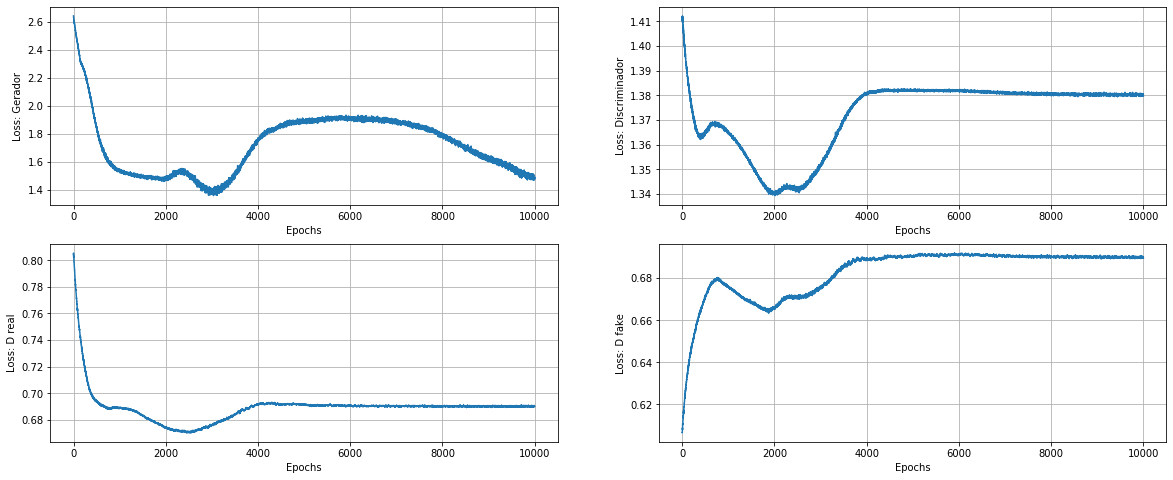

In [17]:
plot_losses(losses_his)

In [25]:
#save networks
# torch.save(G.state_dict(), 'models/g_cond_gan_modified_shap_50k_10k.pt')
# torch.save(D.state_dict(), 'models/d_cond_gan_modified_shap_50k_10k.pt')

## Reproduzindo mais dados como os do dataset inicial

In [31]:
rho

0.26368

Fake total expected income: 439111.91
       Product_price  Click_probability  Expected_income
mean      21.050076           0.416683         8.782238
std        5.479745           0.103560         3.233073
25%       16.760000           0.340000         6.444799
50%       20.129999           0.420000         8.306500
75%       24.459999           0.490000        10.640800
Real total expected income: 439413.67
       Product_price  Click_probability  Expected_income
mean      21.093944           0.416619         8.788273
std        5.840870           0.103044         3.325084
25%       16.730000           0.350000         6.426200
50%       20.120000           0.420000         8.269050
75%       24.380000           0.490000        10.598400


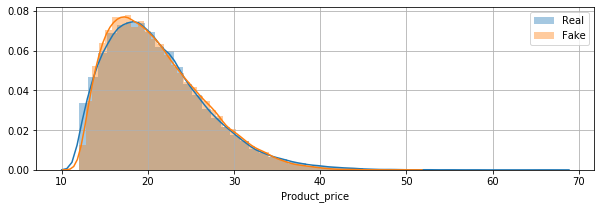

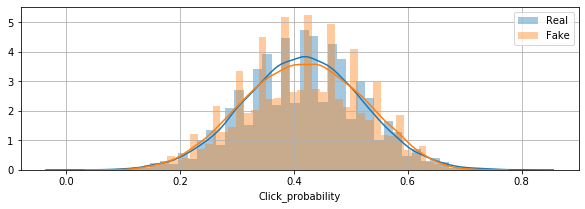

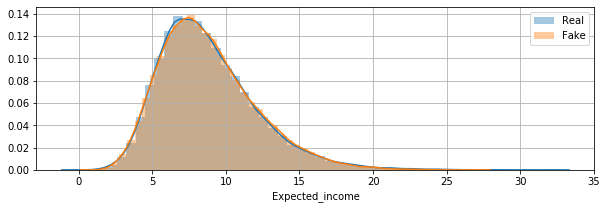

In [32]:
gan_summary(df_num, rho=rho)

## Intervenção

Fake total expected income: 572581.62
       Product_price  Click_probability  Expected_income
mean      22.568855           0.509852        11.451632
std        5.637365           0.078152         3.183373
25%       18.219999           0.460000         9.122475
50%       21.879999           0.510000        11.077100
75%       26.150000           0.560000        13.409101
Real total expected income: 439413.67
       Product_price  Click_probability  Expected_income
mean      21.093944           0.416619         8.788273
std        5.840870           0.103044         3.325084
25%       16.730000           0.350000         6.426200
50%       20.120000           0.420000         8.269050
75%       24.380000           0.490000        10.598400


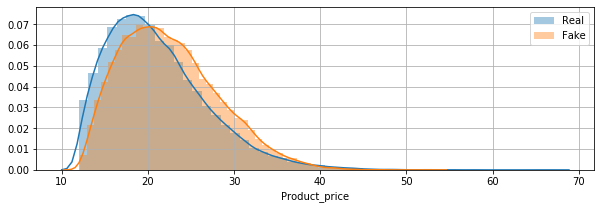

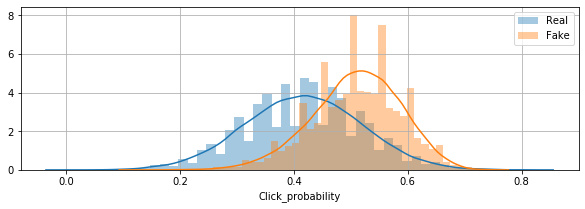

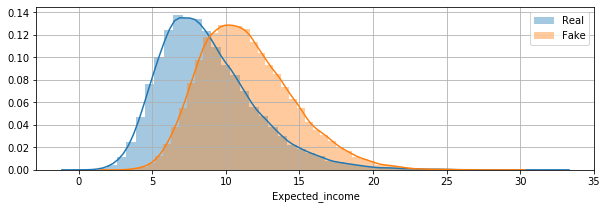

In [23]:
gan_summary(df_num, rho=1)

# Topological tests

In [16]:
import gs
import gudhi as gd
import umap

In [17]:
# bad generator
B = GNet().cuda()

In [18]:
def gen_data(Gen,Z_dim,W_dim,y_tc,batch):
    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    l = y_tc[:batch].cuda()
    return Gen(z,w,l)

In [21]:
X_fake = gen_data(G,Z_dim,W_dim,y_tc,batch=1000)
X_bad = gen_data(B,Z_dim,W_dim,y_tc,batch=1000)

In [20]:
def geometry_score(X_real,X_fake,L_0=64, gamma=1.0/128,  i_max=100, n=500):
    rlt_fake = gs.rlts(X_fake.cpu().data.numpy(), L_0=L_0, gamma=gamma,  i_max=i_max, n=n)
    rlt_real = gs.rlts(X_real.cpu().data.numpy(), L_0=L_0, gamma=gamma,  i_max=i_max, n=n)
    return gs.geom_score(rlt_real, rlt_fake), np.mean(rlt_real, axis=0), np.mean(rlt_fake, axis=0)

In [23]:
geo_score, mrlt_real, mrlt_fake = geometry_score(X_tc[:5000],X_fake,L_0=64, gamma=1.0/128,  i_max=100, n=500)

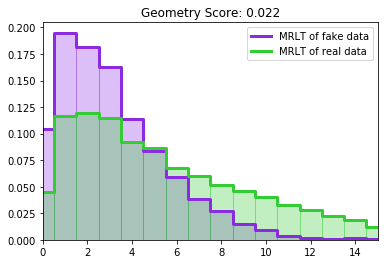

In [24]:
gs.fancy_plot(mrlt_fake, label='MRLT of fake data',color='blueviolet')
gs.fancy_plot(mrlt_real, label='MRLT of real data',color='limegreen')
plt.title('Geometry Score: {:.3f}'.format(geo_score))
plt.xlim([0, 15])
plt.legend()

In [25]:
geo_score, mrlt_real, mrlt_bad = geometry_score(X_tc[:5000],X_bad,L_0=64, gamma=1.0/128,  i_max=100, n=1000)

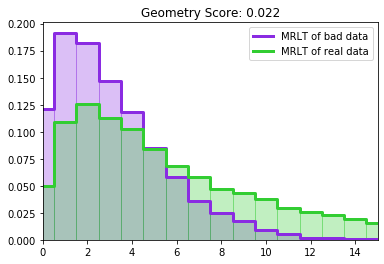

In [27]:
gs.fancy_plot(mrlt_bad, label='MRLT of bad data',color='blueviolet')
gs.fancy_plot(mrlt_real, label='MRLT of real data',color='limegreen')
plt.title('Geometry Score: {:.3f}'.format(geo_score))
plt.xlim([0, 15])
plt.legend()

In [82]:
geo_score, mrlt_fake, mrlt_bad = geometry_score(X_fake,X_bad,L_0=64, gamma=1.0/128,  i_max=100, n=1000)

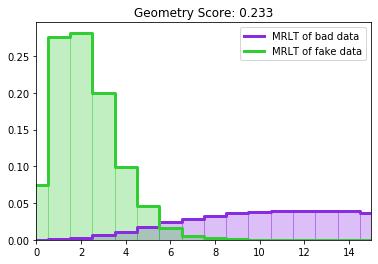

In [83]:
gs.fancy_plot(mrlt_bad, label='MRLT of bad data',color='blueviolet')
gs.fancy_plot(mrlt_fake, label='MRLT of fake data',color='limegreen')
plt.title('Geometry Score: {:.3f}'.format(geo_score))
plt.xlim([0, 15])
plt.legend()

## Gudhi

In [22]:
%%time
X_real_ripscomplex = gd.RipsComplex(points=X_tc[:1000],max_edge_length=0.8) 
Rips_simplex_tree_X_real = X_real_ripscomplex.create_simplex_tree(max_dimension=2)
BarCodes_Rips0_real = Rips_simplex_tree_X_real.persistence()

CPU times: user 1min 44s, sys: 1.78 s, total: 1min 46s
Wall time: 1min 46s


In [25]:
%%time
X_fake_ripscomplex = gd.RipsComplex(points=X_fake,max_edge_length=0.8) 
Rips_simplex_tree_X_fake = X_fake_ripscomplex.create_simplex_tree(max_dimension=2)
BarCodes_Rips0_fake = Rips_simplex_tree_X_fake.persistence()

CPU times: user 1min 47s, sys: 1.87 s, total: 1min 49s
Wall time: 1min 49s


In [26]:
%%time
X_bad_ripscomplex = gd.RipsComplex(points=X_bad,max_edge_length=0.8) 
Rips_simplex_tree_X_bad = X_bad_ripscomplex.create_simplex_tree(max_dimension=2)
BarCodes_Rips0_bad = Rips_simplex_tree_X_bad.persistence()

CPU times: user 46.5 s, sys: 872 ms, total: 47.4 s
Wall time: 47.2 s


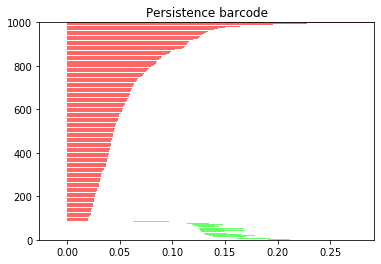

In [24]:
# real data
plot = gd.plot_persistence_barcode(BarCodes_Rips0_real)
plot.show()

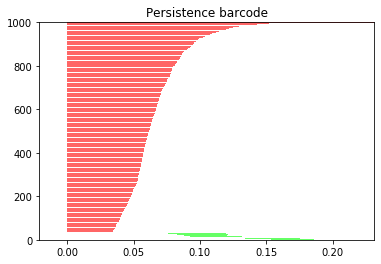

In [28]:
# fake data
plot = gd.plot_persistence_barcode(BarCodes_Rips0_fake)
plot.show()

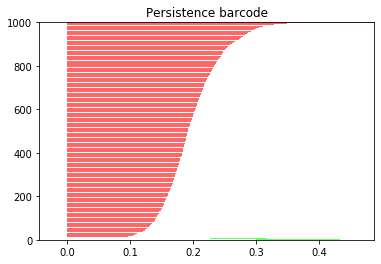

In [30]:
# bad data
plot = gd.plot_persistence_barcode(BarCodes_Rips0_bad)
plot.show()

In [33]:
for i in range(3):
    print(f"Real data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_real.persistence_intervals_in_dimension(i))}")
    print(f"Fake data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_fake.persistence_intervals_in_dimension(i))}")
    print(f"Bad  data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_bad.persistence_intervals_in_dimension(i))}")

Real data: Number o holes in 0 dimension: 999
Fake data: Number o holes in 0 dimension: 1000
Bad  data: Number o holes in 0 dimension: 1000
Real data: Number o holes in 1 dimension: 602
Fake data: Number o holes in 1 dimension: 588
Bad  data: Number o holes in 1 dimension: 1035
Real data: Number o holes in 2 dimension: 0
Fake data: Number o holes in 2 dimension: 0
Bad  data: Number o holes in 2 dimension: 0


In [95]:
for i in range(3):
    print(f"Real data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_real.persistence_intervals_in_dimension(i))}")
    print(f"Fake data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_fake.persistence_intervals_in_dimension(i))}")
    print(f"Bad  data: Number o holes in {i} dimension: {len(Rips_simplex_tree_X_bad.persistence_intervals_in_dimension(i))}")

Real data: Number o holes in 0 dimension: 1000
Fake data: Number o holes in 0 dimension: 1000
Bad  data: Number o holes in 0 dimension: 1000
Real data: Number o holes in 1 dimension: 184
Fake data: Number o holes in 1 dimension: 149
Bad  data: Number o holes in 1 dimension: 481
Real data: Number o holes in 2 dimension: 0
Fake data: Number o holes in 2 dimension: 0
Bad  data: Number o holes in 2 dimension: 0


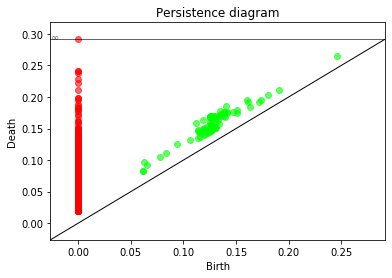

In [34]:
gd.plot_persistence_diagram(BarCodes_Rips0_real);

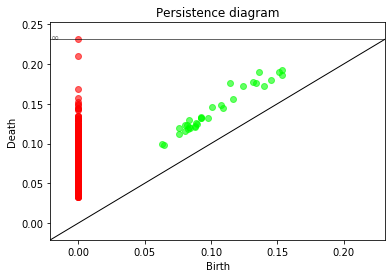

In [35]:
gd.plot_persistence_diagram(BarCodes_Rips0_fake);

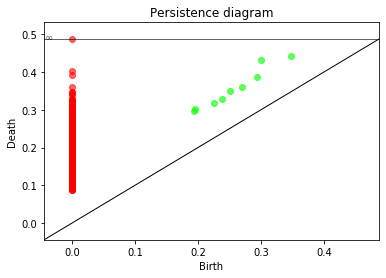

In [36]:
gd.plot_persistence_diagram(BarCodes_Rips0_bad);

## UMAP

In [38]:
%%time
embedding_real = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='euclidean').fit_transform(X_tc)
embedding_fake = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='euclidean').fit_transform(X_fake.cpu().data.numpy())
embedding_bad = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='euclidean').fit_transform(X_bad.cpu().data.numpy())

CPU times: user 4min 48s, sys: 1min 6s, total: 5min 55s
Wall time: 1min 5s


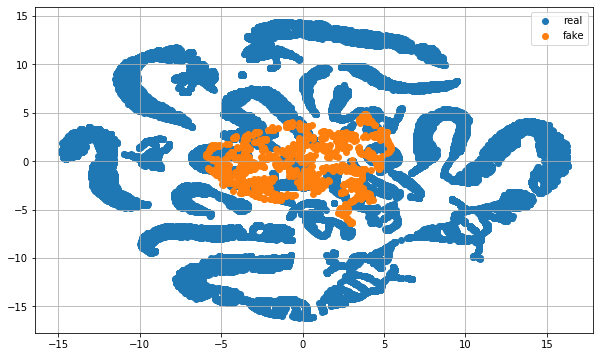

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real")
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

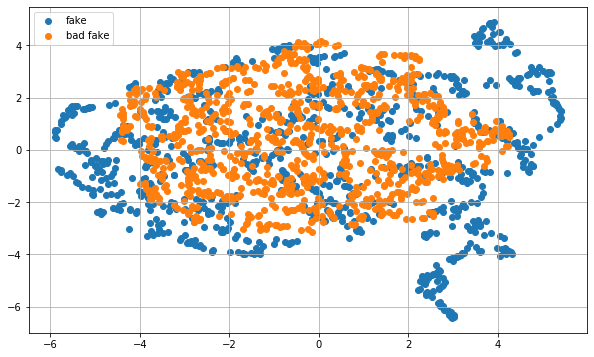

In [41]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake")
plt.scatter(x=embedding_bad[:,0],y=embedding_bad[:,1],label="bad fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

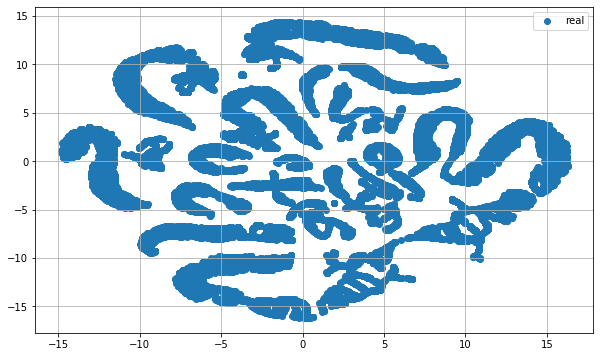

In [42]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real")
plt.legend(loc=0)
plt.grid(True)
plt.show()

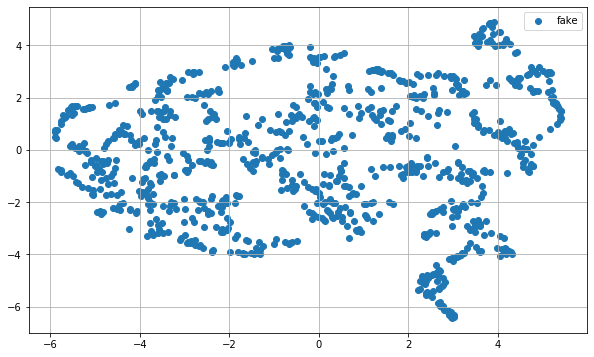

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

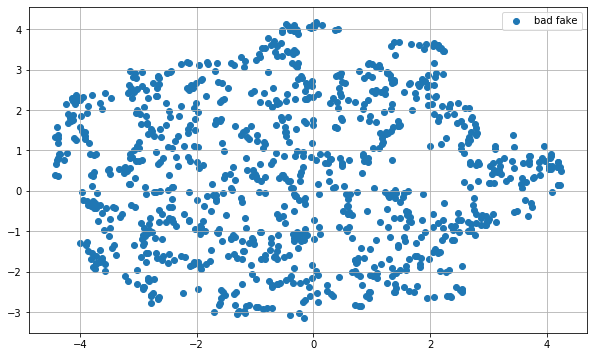

In [44]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_bad[:,0],y=embedding_bad[:,1],label="bad fake")
plt.legend(loc=0)
plt.grid(True)
plt.show()

In [45]:
%%time
embedding_real = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='correlation').fit_transform(X_tc)
embedding_fake = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='correlation').fit_transform(X_fake.cpu().data.numpy())
embedding_bad = umap.UMAP(n_neighbors=10,min_dist=0.1,n_epochs=200,
                      metric='correlation').fit_transform(X_bad.cpu().data.numpy())

CPU times: user 2min 21s, sys: 27.3 s, total: 2min 49s
Wall time: 50.1 s


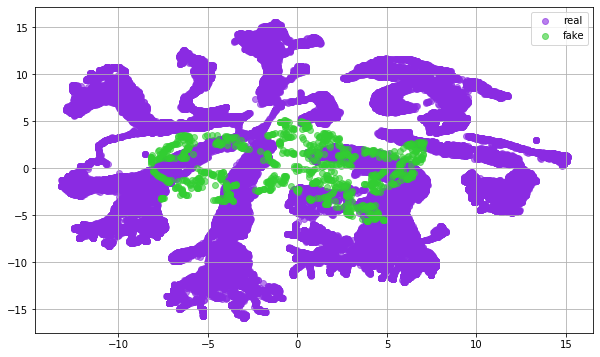

In [54]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real",color='blueviolet',alpha=0.6)
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake",color='limegreen',alpha=0.6)
plt.legend(loc=0)
plt.grid(True)
plt.show()

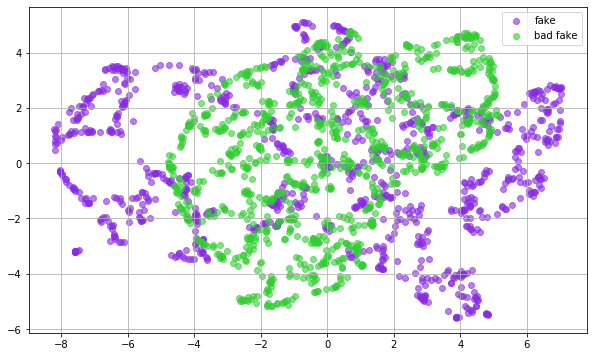

In [55]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake",color='blueviolet',alpha=0.6)
plt.scatter(x=embedding_bad[:,0],y=embedding_bad[:,1],label="bad fake",color='limegreen',alpha=0.6)
plt.legend(loc=0)
plt.grid(True)
plt.show()

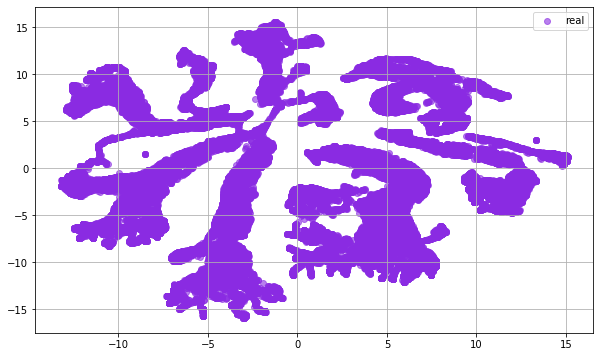

In [56]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_real[:,0],y=embedding_real[:,1],label="real",color='blueviolet',alpha=0.6)
plt.legend(loc=0)
plt.grid(True)
plt.show()

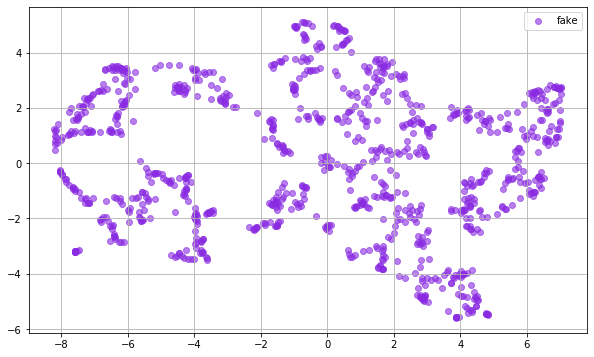

In [57]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_fake[:,0],y=embedding_fake[:,1],label="fake",color='blueviolet',alpha=0.6)
plt.legend(loc=0)
plt.grid(True)
plt.show()

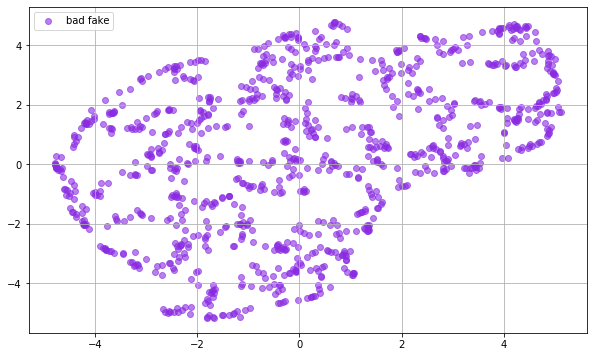

In [58]:
plt.figure(figsize=(10,6))
plt.scatter(x=embedding_bad[:,0],y=embedding_bad[:,1],label="bad fake",color='blueviolet',alpha=0.6)
plt.legend(loc=0)
plt.grid(True)
plt.show()